In [50]:
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense,Input,Embedding,Flatten, Bidirectional
from tensorflow.keras.models import Model
import numpy as np
from sklearn import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [51]:
from textaugment import EDA
columns = ['学号', '性别', '生源地', '总分', '幻觉、妄想症状', '自杀意图', '焦虑指标总分', '抑郁指标总分', '偏执指标总分', '自卑指标总分',
               '敏感指标总分', '社交恐惧指标总分', '躯体化指标总分', '依赖指标总分', '敌对攻击指标总分', '冲动指标总分', '强迫指标总分',
               '网络成瘾指标总分', '自伤行为指标总分', '进食问题指标总分', '睡眠困扰指标总分', '学校适应困难指标总分', '人际关系困扰指标总分',
               '学业压力指标总分', '就业压力指标总分', '恋爱困扰指标总分']
data = pd.read_csv('student_data.csv', encoding='utf-8')
data.drop(columns=columns, inplace=True)

In [52]:
data.loc[data['可能问题'] != 0, '可能问题'] = 1
data['可能问题'].value_counts()

0    106
1     72
Name: 可能问题, dtype: int64

In [53]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=8)

In [54]:
# # augment training data
# train_class_0 = train_df[train_df['可能问题']==0]
# train_class_1 = train_df[train_df['可能问题']==1]
# train_class_2 = train_df[train_df['可能问题']==2]
# train_class_3 = train_df[train_df['可能问题']==3]
#
# t = EDA(random_state=8)
# new_text_1 = [t.random_swap(t.random_insertion(t.random_deletion(t.synonym_replacement(sent), p=0.4))) for sent in train_class_1['text']]
# new_text_2 = [t.random_swap(t.random_insertion(t.random_deletion(t.synonym_replacement(sent), p=0.4))) for sent in train_class_2['text']]
# new_text_3 = [t.random_swap(t.random_insertion(t.random_deletion(t.synonym_replacement(sent), p=0.4))) for sent in train_class_3['text']]
#
# new_class_1 = train_class_1
# new_class_1['text'] = new_text_1
# train_1 = pd.concat([train_class_1, new_class_1])
#
# new_class_2 = train_class_2
# new_class_2['text'] = new_text_2
# train_2 = pd.concat([train_class_2, new_class_2])
#
# new_class_3 = train_class_3
# new_class_3['text'] = new_text_3
# train_3 = pd.concat([train_class_3, new_class_3])
#
# train = pd.concat([train_class_0, train_1, train_2, train_3])
# train['可能问题'].value_counts()


In [55]:
train_metadata = np.array(train_df.iloc[:, 0:-2])
test_metadata = np.array(test_df.iloc[:, 0:-2])
print('train_metadata shape:', train_metadata.shape)
print('test_metadata shape:', test_metadata.shape)

train_metadata shape: (142, 22)
test_metadata shape: (36, 22)


In [56]:
texts = np.array(pd.concat([train_df['text'], test_df['text']]))
len(texts)

178

In [57]:
MAX_NB_WORDS = 5000
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
len(sequences)
# sequences即将每个句子中的每个单词使用词典序表示的形式

C:\Users\hamburger_sct\Anaconda3\envs\nlp_env\lib\site-packages\keras_preprocessing\text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


178

In [58]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 6375 unique tokens


In [59]:
MAX_SEQUENCE_LENGTH = 300
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [60]:
labels = to_categorical(np.array(pd.concat([train_df['可能问题'], test_df['可能问题']])))

In [61]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (178, 300)
Shape of label tensor: (178, 2)


In [62]:
indices = np.arange(data.shape[0])
data = data[indices]
labels = labels[indices]

X_train = data[:len(train_df)]
X_test = data[len(train_df):]
y_train = np.array(train_df['可能问题'])
y_test = np.array(test_df['可能问题'])

print('number of sequences in X_train: ', len(X_train))
print('number of sequences in X_test: ', len(X_test))
print(len(y_train))
print(len(y_test))

number of sequences in X_train:  142
number of sequences in X_test:  36
142
36


In [63]:
# Preparing the Embedding Layer
embedding_index = {}
f = open('./glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [81]:
# embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[index]) != len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[index])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[index] = embedding_vector

In [98]:
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [99]:
metadata_input = Input(shape=(train_metadata.shape[1],), dtype='float32')
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_model = Dropout(0.5)(embedded_sequences)
l_model = Bidirectional(keras.layers.LSTM(128, recurrent_dropout=0.2))(l_model)
l_model = Dropout(0.5)(l_model)

r_dense = keras.layers.Dense(256, activation='relu')(metadata_input)
r_dense = keras.layers.Dropout(0.5)(r_dense)
r_dense = keras.layers.Dense(128, activation='relu')(r_dense)
# r_dense = keras.layers.Dropout(dropout)(r_dense)

c_merge = keras.layers.Concatenate(axis=1)([l_model, r_dense])
c_dense = keras.layers.Dense(1024, activation='relu')(c_merge)
preds = keras.layers.Dense(4)(c_dense)
preds = keras.layers.Activation('softmax')(preds)

model = Model([sequence_input, metadata_input], preds)
model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

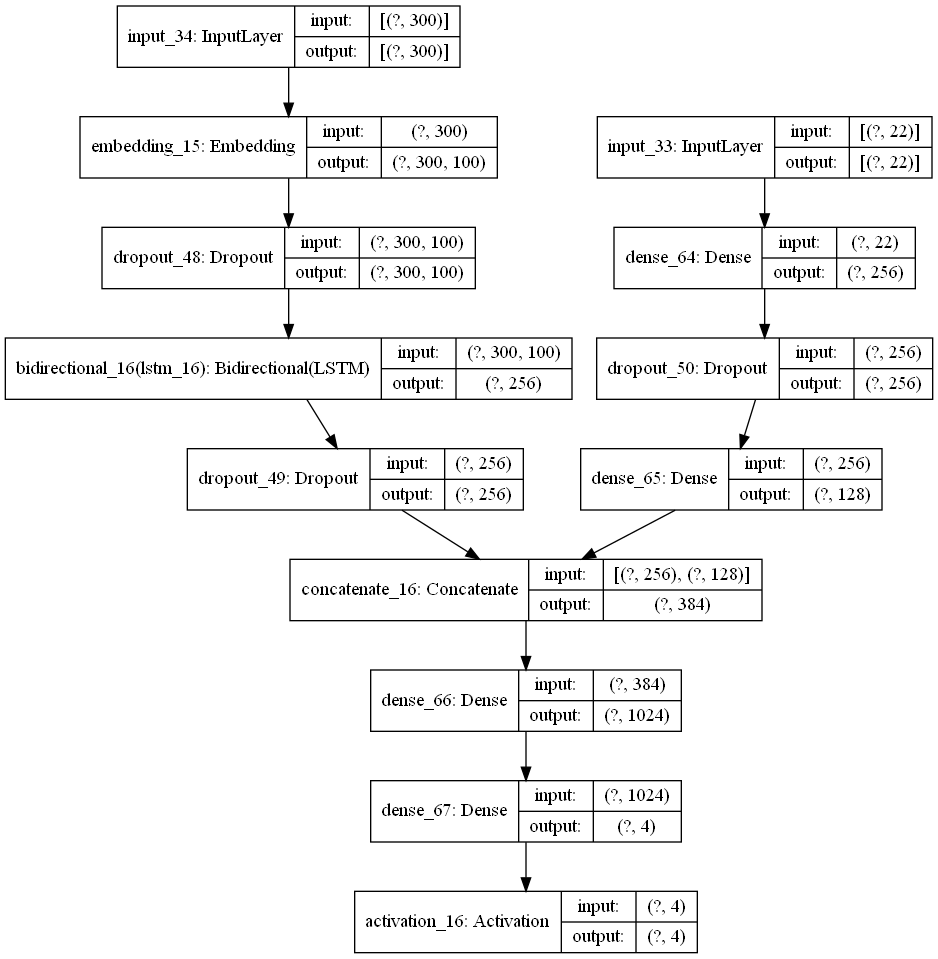

In [100]:
keras.utils.plot_model(model, "LSTM_metadata_model.png", show_shapes=True)

In [101]:
model.fit([X_train, train_metadata], y_train,
          validation_data=([X_test, test_metadata], y_test),
          epochs=50,
          batch_size=100,
          verbose=2)
predicted = model.predict([X_test, test_metadata])
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))
print("precision: ", str(metrics.precision_score(y_test, predicted, average='macro')))
print("accuracy: ", str(metrics.accuracy_score(y_test, predicted)))
print("F1 score: ", str(metrics.f1_score(y_test, predicted, average='macro')))
print("recall: ", str(metrics.recall_score(y_test, predicted, average='macro')))

Train on 142 samples, validate on 36 samples
Epoch 1/50
142/142 - 20s - loss: 1.2459 - accuracy: 0.4507 - val_loss: 0.7521 - val_accuracy: 0.7222
Epoch 2/50
142/142 - 18s - loss: 0.6115 - accuracy: 0.8310 - val_loss: 0.5324 - val_accuracy: 0.8056
Epoch 3/50
142/142 - 16s - loss: 0.4029 - accuracy: 0.8521 - val_loss: 0.5054 - val_accuracy: 0.7778
Epoch 4/50
142/142 - 16s - loss: 0.3177 - accuracy: 0.8521 - val_loss: 0.5371 - val_accuracy: 0.7500
Epoch 5/50
142/142 - 16s - loss: 0.3009 - accuracy: 0.8451 - val_loss: 0.5819 - val_accuracy: 0.7222
Epoch 6/50
142/142 - 16s - loss: 0.2678 - accuracy: 0.8662 - val_loss: 0.6665 - val_accuracy: 0.6667
Epoch 7/50
142/142 - 16s - loss: 0.2862 - accuracy: 0.8803 - val_loss: 0.6328 - val_accuracy: 0.6667
Epoch 8/50
142/142 - 16s - loss: 0.1727 - accuracy: 0.9085 - val_loss: 0.6348 - val_accuracy: 0.6944
Epoch 9/50
142/142 - 16s - loss: 0.2417 - accuracy: 0.8873 - val_loss: 0.6205 - val_accuracy: 0.6944
Epoch 10/50
142/142 - 16s - loss: 0.1877 - acc